In [1]:
import numpy as np
from numpy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd as rsvd
import matplotlib.pyplot as plt
import h5py
from sklearn import preprocessing as norm


# Task 1

In [2]:
N = 2000
rank = 2
A = np.random.normal(0, 1, (N, N))

In [3]:
%%timeit
svd(A)

6.78 s ± 1.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%%timeit
svds(A, k = rank)

33.3 s ± 2.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
rsvd(A, N)

13.2 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
def find_needed_rank_multiply(svd: np.array, rank: int):
    return svd[0][:,:rank] @ np.diag(svd[1][:rank]) @ svd[2][:rank,:]

A_svd = find_needed_rank_multiply(svd = svd(A), rank = rank)
A_svds = find_needed_rank_multiply(svd = svds(A, k = rank), rank = rank)
A_rsvd = find_needed_rank_multiply(svd = rsvd(A, N), rank = rank)
for matrix in (A_svd, A_svds, A_rsvd):
    print(np.linalg.norm(A - matrix, ord = "fro"))
    
# почти одинаковые нормы

1994.7609716148079
1994.7609716148083
1994.7609716148074


# Task 2

 $A = U\Sigma V^T$. 



 (i) $\left(A^T A\right)^{-1} = ((U\Sigma V^T)^T U\Sigma V^T)^{-1}  = (V \Sigma^T U^T U\Sigma V^T)^{-1} =
  (V \Sigma^T \Sigma V^T)^{-1} = (V \Sigma^2 V^T)^{-1}  = V \Sigma^{-2} V^T $

(ii)  $\left(A^T A\right)^{-1}A^T = V \Sigma^{-2} V^T A^T  = V \Sigma^{-2} V^T V \Sigma^T U^T =  V \Sigma^{-2}\Sigma^T U^T = V \Sigma^{-1} U^T$ 

(iii) $A\left(A^T A\right)^{-1} = U\Sigma V^T V \Sigma^{-2} V^T = U\Sigma \Sigma^{-2} V^T = U \Sigma^{-1} V^T$

(iv) $A\left(A^T A\right)^{-1}A^T = U\Sigma V^T V \Sigma^{-2} V^T V \Sigma^T U^T = U\Sigma  \Sigma^{-2} \Sigma^T U^T   = U U^T = 1$ 

# Task 3

In [7]:
A = np.matrix([[-2,11],[-10,5]])
u, s, vt = svd(A)
print("Left singular vectors:")
print(u)
print("Right singular vectors:")
print(vt)
print("Singular values:")
print(s)

Left singular vectors:
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
Right singular vectors:
[[ 0.6 -0.8]
 [-0.8 -0.6]]
Singular values:
[14.14213562  7.07106781]


In [8]:
# чтобы выбрать с минимальным числом минусов достаточно:
u, vt = -u, -vt
u@np.diag(s)@vt # == A

matrix([[ -2.,  11.],
        [-10.,   5.]])

In [9]:
x_circle = np.linspace(-1.0, 1.0, 1000)
x_circle = x_circle 
y_circle = np.sqrt(1 - x_circle**2)
circle = np.vstack([np.concatenate([x_circle, -x_circle]), np.concatenate([y_circle, -y_circle])])

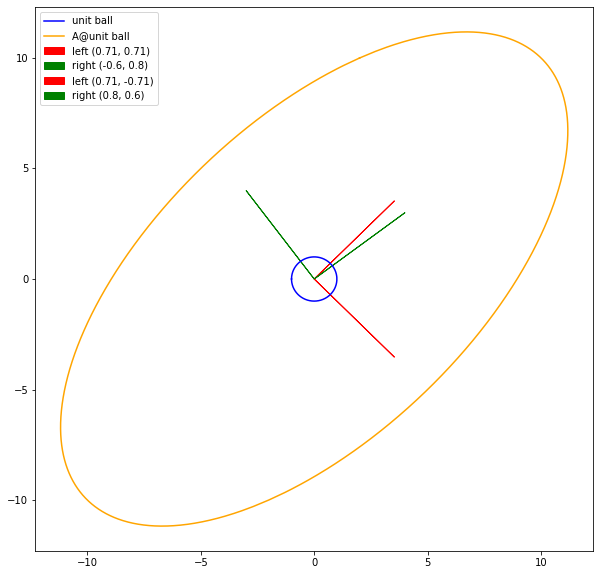

In [10]:
plt.figure(figsize=(10,10))
plt.plot(circle[0], circle[1], color = "blue", label = "unit ball")
A_circle = np.array(A@circle)
plt.plot(A_circle[0], A_circle[1], color = "orange", label = "A@unit ball")
for i in range(0, 2):
    # векторы увеличены в 5 раз для лучшей видимости
    plt.arrow(0, 0, 5*u[0, i], 5*u[i, 1], label = f"left {round(u[0, i], 2), round(u[i, 1], 2)}", color = "red")
    plt.arrow(0, 0, 5*vt[0, i], 5*vt[i, 1], label = f"right {round(vt[0, i], 2), round(vt[i, 1], 2)}", color = "green")


plt.legend()
plt.show()

In [11]:
print(f'Frobenius norm of A: {np.sqrt(np.sum(np.square(np.diag(s))))}')
print(f'2-norm of A:         {np.max(np.diag(s))}')

print('Inverse A:')
print(vt.T@np.diag(s**(-1))@u.T)

print(f'Eigen values of A:   {np.linalg.eig(A)[0]}')

Frobenius norm of A: 15.811388300841895
2-norm of A:         14.142135623730947
Inverse A:
[[ 0.05 -0.11]
 [ 0.1  -0.02]]
Eigen values of A:   [1.5+9.88685997j 1.5-9.88685997j]


# Task 4

In [12]:
with h5py.File('A.hdf', "r") as f:
    A_ = f["A"]["block0_values"][()]
    f.close()

def get_error(k_: int):
    A_svds = svds(A_, k = k_)
    h = A_svds[0][:,:k_] @ np.diag(A_svds[1][:k_])
    nu = A_svds[2][:k_,:]
    h_nu = h@nu
    sigma_err = np.sqrt(np.sum((A_ - h_nu)**2))/np.sqrt(np.sum(A_**2))
    return sigma_err

In [13]:
# K = 1, плохо
get_error(1)

0.7742251888975445

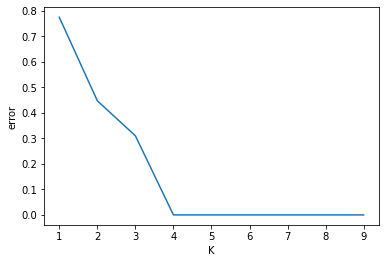

In [14]:
k_range = range(1, 10)
errors = [get_error(x) for x in k_range]
plt.plot(k_range, errors)
plt.xlabel("K")
plt.ylabel("error")
plt.show()
# 4 достаточно

# Task 5

In [15]:
with h5py.File('digits.hdf', "r") as f:
    data = f["images"]['block0_values'][()].reshape(1797, 64)
    labels = f["labels"]['values'][()] 
    f.close()

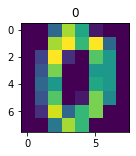

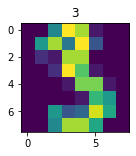

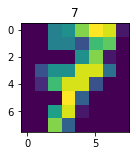

In [16]:
for i in (0, 3, 7):
    plt.figure(figsize=(2,2))
    plt.title(i)
    plt.imshow(data[i].reshape(8, 8))

In [17]:
A_norm = norm.scale(data)

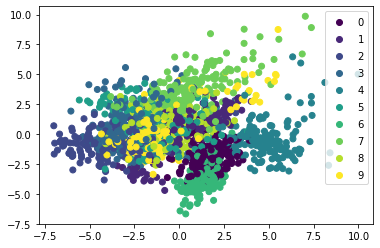

In [18]:
U5, S5, Vе5 = rsvd(A_norm, 2)
A_5 = U5*S5

p = plt.scatter(x = A_5[:, 0], y = A_5[:, 1], c = labels)
plt.gca()
plt.legend(*p.legend_elements())